#Import Dependecies

In [1]:
#import dependencies
!pip install tweepy==4.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 2.6 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0


In [135]:
import tweepy
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#Twitter Authentication

In [3]:
cilent = tweepy.Client(bearer_token="AAAAAAAAAAAAAAAAAAAAADv%2BhAEAAAAAVXByzn%2B6omgnBG8uo0QypoGPb8k%3DuwbRMlVA0oYjr4U4VaB14jn0RCgnq0XcvFIgZeer6HO8Q7udrW")

#Create DataFrame

In [231]:
query = "#Putin lang:en -is:retweet -result_type=latest"

In [232]:
paginator = tweepy.Paginator(cilent.search_recent_tweets,query=query,max_results=100,limit=20)
# available fields [query,start_time,end_time,since_id,until_id,max_results,next_token,pagination_token,sort_order,expansions,tweet.fields,media.fields,poll.fields,place.fields,user.fields]

In [233]:
tweet_list = []
for t in paginator.flatten():
  tweet_list.append(t)
  print(t)

President #Putin and the audience cheering Russia Russia.

 The President of the European Council says: Russia is putting world security at risk. https://t.co/nf67091i6X
Putin FCK U and your (political) family #Putin #Russland https://t.co/lRKRxLQoGj
It's your day. My female journalist! Kichomin we tupjet. Enjoy your day! #Chemutaigoin #BREAKING_NEWS #Putin #kalonzo #HELD #meru #Ebola https://t.co/PCDzTaaHaU
Putin: West Lies. #Putin: West Lies. Putin: West lies. Putin: West lies. Putin: West lies.
Putin annexes four occupied regions; Ukraine accelerates NATO membership bid

#Putin #Ukraine https://t.co/SzJtlx0tEX
#US #sanctions more than 1,000 #Russians, firms, rejecting #Putin's 'fraudulent' annexation of #Ukrainian regions, reports AP
Check out this new digital art that I uploaded to https://t.co/f1IowKz0Ax! https://t.co/wH7ucgleCV #VoteBlueForSoManyReasons #Jan6 #espionagetrump #TrumpIsGoingToJail #GOPTaxScam #Putin #UkraineWillWin #WomensRights #Roevember #DemocratsDeliver #BlueWav

#create dataframe

In [234]:
tweet_df = pd.DataFrame(tweet_list) 
tweet_df.head(5)

,edit_history_tweet_ids,id,text
0,[1575859068379418625],1575859068379418625,President #Putin and the audience cheering Rus...
1,[1575859055842586624],1575859055842586624,Putin FCK U and your (political) family #Putin...
2,[1575859052726272001],1575859052726272001,It's your day. My female journalist! Kichomin ...
3,[1575859051342110720],1575859051342110720,Putin: West Lies. #Putin: West Lies. Putin: We...
4,[1575859045151318017],1575859045151318017,Putin annexes four occupied regions; Ukraine a...


In [235]:
tweet_df = pd.DataFrame(tweet_df['text'])
tweet_df

,text
0,President #Putin and the audience cheering Rus...
1,Putin FCK U and your (political) family #Putin...
2,It's your day. My female journalist! Kichomin ...
3,Putin: West Lies. #Putin: West Lies. Putin: We...
4,Putin annexes four occupied regions; Ukraine a...
...,...
1995,@Chinamission2un @IndiaUNNewYork \n\nTime to c...
1996,#Putin \nIn his speech Putin addressed to the ...
1997,People are gathering around the Red Square in ...
1998,#Putin speech is to die for !! Hahahahaha all ...


In [236]:
tweet_df.shape

(2000, 1)

In [237]:
v = tweet_df['text'][1].lower()
v

'putin fck u and your (political) family #putin #russland https://t.co/lrkrxlqogj'

In [238]:
v = re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(@[A-Za-z0-9]+)"," ",v)
v = re.sub(r"\s+[a-zA-Z]\s+",' ',v)
v = re.sub(r"\s+",' ',v)
v

'putin fck and your political family putin russland '

#Preprocessing

In [239]:
def cleaning(s):
  sent = s.lower()
  sent = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sent)
  sent = re.sub(r"\s+[a-zA-Z]\s+", ' ', sent)
  sent = re.sub(r'\s+', ' ', sent)
  return sent

In [240]:
cleaned_tweets = []
for t in tweet_df['text']:
  c = cleaning(t)
  cleaned_tweets.append(c)

In [241]:
cleaned_tweets[1]

'putin fck and your political family putin russland '

In [242]:
tweet_dfc = pd.DataFrame(cleaned_tweets,columns=['text'])
tweet_dfc

,text
0,president putin and the audience cheering russ...
1,putin fck and your political family putin russ...
2,it your day my female journalist kichomin we t...
3,putin west lies putin west lies putin west lie...
4,putin annexes four occupied regions ukraine ac...
...,...
1995,time to cut this criminal thug loose he is se...
1996,putin in his speech putin addressed to the en...
1997,people are gathering around the red square in ...
1998,putin speech is to die for hahahahaha all his...


#NLP

In [243]:
from ast import Lambda
from textblob import TextBlob
for i in tweet_dfc.index.values:
  p,s = pd.Series(TextBlob(tweet_dfc['text'][i]).sentiment)
  tweet_dfc.at[i,'polarity']=p
  tweet_dfc.at[i,'subjectivity']=s


In [244]:
for index, row in tweet_dfc['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_dfc.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_dfc.loc[index, 'sentiment'] = "positive"
    else:
        tweet_dfc.loc[index, 'sentiment'] = "neutral"
    
    tweet_dfc.loc[index, 'neg'] = neg
    tweet_dfc.loc[index, 'neu'] = neu
    tweet_dfc.loc[index, 'pos'] = pos
    tweet_dfc.loc[index, 'compound'] = comp
tweet_dfc.head(5)

,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,president putin and the audience cheering russ...,0.0,0.000000,positive,0.078,0.709,0.213,0.5574
1,putin fck and your political family putin russ...,0.0,0.100000,neutral,0.000,1.000,0.000,0.0000
2,it your day my female journalist kichomin we t...,0.2,0.333333,positive,0.000,0.856,0.144,0.4939
3,putin west lies putin west lies putin west lie...,0.0,0.000000,negative,0.583,0.417,0.000,-0.9186
4,putin annexes four occupied regions ukraine ac...,0.0,0.000000,neutral,0.000,1.000,0.000,0.0000


#viz

In [245]:
#Creating new dataframes for all sentiments (positive, negative and neutral)
tweet_df_negative = tweet_dfc[tweet_dfc["sentiment"]=="negative"]
tweet_df_positive = tweet_dfc[tweet_dfc["sentiment"]=="positive"]
tweet_df_neutral = tweet_dfc[tweet_dfc["sentiment"]=="neutral"]

In [246]:
#Function for count_values_in single columns
def count_values_in_column(data,feature):
    total = data.loc[:,feature].value_counts(dropna=False).sum()
    percentage = (data.loc[:,feature].value_counts(dropna=False)*100)/total
    return pd.DataFrame([percentage]).T
#Count_values for sentiment
res = count_values_in_column(tweet_dfc,"sentiment")
res

,sentiment
negative,43.50
positive,30.05
neutral,26.45


In [247]:
for i in tweet_df_positive['text']:
  print(i,"\n")

president putin and the audience cheering russia russia the president of the european council says russia is putting world security at risk  

it your day my female journalist kichomin we tupjet enjoy your day chemutaigoin breaking news putin kalonzo held meru ebola  

last call to sell everything ukraine submit an application to join nato nato adbe tsla qqq spy crypto aapl nvda news bitcoin msft amzn roku rblx rcl apple shop tesla putin biden amd ukraine  

 the s on friday sanctioned more than 1 000 people and firms connected to russia invasion of ukraine including its central bank governor and families of national security council members ukrainerussiawar ukrainewar sanctions putin 

 putin acts like hitler amp stalin that is the responsibility of merkel amp schr der iiiww life worth living is life that does not fear death there will be no return of the ussr ukraine will win democracy will win putin out  

 en see ukraine as european with much to do on path to eu membership that the

In [248]:
for i in tweet_df_negative['text'][:20]:
  print(i,'\n')

putin west lies putin west lies putin west lies putin west lies putin west lies  

 us sanctions more than 1 000 russians firms rejecting putin fraudulent annexation of ukrainian regions reports ap 

 putin is the most dumb fuck on earth stayoff vodka 

i wonder what general would push the lunch button if putin were to order nuclear strike for war of one man not russia russia is not at war putin is and is willing to send russian children to die for him but not his own children not is kids  

putin proclaimed annexation seems sign of his desperation at losing the war he resorting to reckless amp delusional speech to delay ukraine pressing advantage the russian people would do well to remove him before he kills them ukraine putin 

 putin says the us set precedent after using nuclear weapons in japan 

the eu condemns the russian annexation of the occupied ukrainian territories and will never accept the illegal referendums that russia staged in the ukrainian regions of kherson zaporizhzh

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """Entry point for launching an IPython kernel.


([<matplotlib.patches.Wedge at 0x7f1696b5b750>,
 [Text(0.2230660168241957, 1.0771450933547382, 'negative'),
  Text(-0.9459354834715434, -0.5614321518308847, 'positive'),
  Text(0.7415909379442079, -0.8124302313177607, 'neutral')])

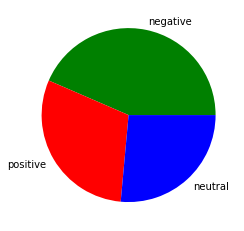

In [249]:
plt.pie(res, labels=res.index, colors=['green','red','blue'])
